# LSTM을 이용한 텍스트 생성
- 데이터 다운로드: 캐글 New York Times Comments
- ArticlesApril2018.csv

In [1]:
from google.colab import files
up = files.upload()

Saving ArticlesApril2018.csv to ArticlesApril2018.csv


In [2]:
import pandas as pd

df = pd.read_csv('ArticlesApril2018.csv', encoding='latin1')
df.head(3)

,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,5adf6684068401528a2aa69b,781,By JOHN BRANCH,article,Former N.F.L. Cheerleadersâ Settlement Offer...,"['Workplace Hazards and Violations', 'Football...",68,Sports,0,2018-04-24 17:16:49,Pro Football,"âI understand that they could meet with us, ...",The New York Times,News,https://www.nytimes.com/2018/04/24/sports/foot...
1,5adf653f068401528a2aa697,656,By LISA FRIEDMAN,article,E.P.A. to Unveil a New Rule. Its Effect: Less ...,"['Environmental Protection Agency', 'Pruitt, S...",68,Climate,0,2018-04-24 17:11:21,Unknown,The agency plans to publish a new regulation T...,The New York Times,News,https://www.nytimes.com/2018/04/24/climate/epa...
2,5adf4626068401528a2aa628,2427,By PETE WELLS,article,"The New Noma, Explained","['Restaurants', 'Noma (Copenhagen, Restaurant)...",66,Dining,0,2018-04-24 14:58:44,Unknown,Whatâs it like to eat at the second incarnat...,The New York Times,News,https://www.nytimes.com/2018/04/24/dining/noma...


### 데이터 전처리: headline 컬럼만 이용

In [3]:
# Null이 있는지 확인
df.headline.isnull().sum()

0

In [4]:
# headline 컬럼: Series 타입 --> list로 변환
headlines = df.headline.values.tolist()        # df.headline.to_list()[:5] 도 동일한 결과 나옴

In [5]:
headlines[:5]

['Former N.F.L. Cheerleadersâ\x80\x99 Settlement Offer: $1 and a Meeting With Goodell',
 'E.P.A. to Unveil a New Rule. Its Effect: Less Science in Policymaking.',
 'The New Noma, Explained',
 'Unknown',
 'Unknown']

In [6]:
len(headlines)

1324

In [7]:
# 노이즈 데이터 ('UnKnown') 제거
headlines = [line for line in df.headline.values if line != 'Unknown']
len(headlines)

1214

In [8]:
# encoding, 구두점 제거, 소문자로 변환
import re
def preprocessing(s):
    s = s.encode('utf8').decode('ascii','ignore')
    s = re.sub('[^A-Za-z0-9 ]', '', s)
    return s.lower()

In [9]:
headlines = [preprocessing(line) for line in headlines]
headlines[:5]

['former nfl cheerleaders settlement offer 1 and a meeting with goodell',
 'epa to unveil a new rule its effect less science in policymaking',
 'the new noma explained',
 'how a bag of texas dirt  became a times tradition',
 'is school a place for selfexpression']

### Keras 텍스트 전처리

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [11]:
# 단어 집합 생성
t = Tokenizer()
t.fit_on_texts(headlines)

In [12]:
# 단어 집합 크기 - Keras Tokenizer의 시작 인덱스가 1이기 때문에
vocab_size = len(t.word_index) + 1  
vocab_size

3494

In [13]:
sequences = []
for line in headlines:
    encoded = t.texts_to_sequences([line])[0]
    for i in range(1,len(encoded)):
        sequences.append(encoded[:i+1])

sequences[:11]

[[99, 269],
 [99, 269, 371],
 [99, 269, 371, 1115],
 [99, 269, 371, 1115, 582],
 [99, 269, 371, 1115, 582, 52],
 [99, 269, 371, 1115, 582, 52, 7],
 [99, 269, 371, 1115, 582, 52, 7, 2],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10, 1116],
 [100, 3]]

In [14]:
max_len = max(len(seq) for seq in sequences)
max_len

24

In [15]:
sequences = pad_sequences(sequences, maxlen=max_len, padding='pre')
sequences[:3]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          99,  269],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   99,
         269,  371],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   99,  269,
         371, 1115]], dtype=int32)

In [16]:
X = sequences[:, :-1]
y = sequences[:, -1]
Y = to_categorical(y)   # one-hot encoding
X.shape, Y.shape

((7803, 23), (7803, 3494))

### 모델 정의/설정/학습
- 이전 모델
    - Embedding: 10 차원
    - LSTM: 128 units

In [17]:
import numpy as np
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

- Embedding 10차원
- LSTM: 64 units

In [20]:
model1 = Sequential([
    Embedding(vocab_size, 10, input_length=max_len-1), # max_len에 y값 포함되기 때문에 -1 필요
    LSTM(64),
    Dense(vocab_size, activation='softmax')
])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 23, 10)            34940     
                                                                 
 lstm_1 (LSTM)               (None, 64)                19200     
                                                                 
 dense_1 (Dense)             (None, 3494)              227110    
                                                                 
Total params: 281,250
Trainable params: 281,250
Non-trainable params: 0
_________________________________________________________________


In [21]:
model1.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [22]:
%time hist1 = model1.fit(X, Y, epochs=200, verbose=0)

CPU times: user 6min 39s, sys: 54.3 s, total: 7min 33s
Wall time: 8min 24s


In [23]:
hist1.history['accuracy'][-1]

0.8712033629417419

- Embedding 16차원
- LSTM: 64 units

In [27]:
model2 = Sequential([
    Embedding(vocab_size, 16, input_length=max_len-1), # max_len에 y값 포함되기 때문에 -1 필요
    LSTM(64),
    Dense(vocab_size, activation='softmax')
])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 23, 16)            55904     
                                                                 
 lstm_4 (LSTM)               (None, 64)                20736     
                                                                 
 dense_4 (Dense)             (None, 3494)              227110    
                                                                 
Total params: 303,750
Trainable params: 303,750
Non-trainable params: 0
_________________________________________________________________


In [28]:
model2.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [29]:
%time hist2 = model2.fit(X, Y, epochs=200, verbose=0)

CPU times: user 6min 38s, sys: 53.2 s, total: 7min 31s
Wall time: 7min 23s


In [30]:
hist2.history['accuracy'][-1]

0.8942714333534241

##### ▶ LSTM 유닛의 갯수가 동일할 때, Embedding vector 차원이 높은 것이 정확도 더 높음.

- Embedding 16차원
- LSTM: 128 units

In [31]:
model3 = Sequential([
    Embedding(vocab_size, 16, input_length=max_len-1), # max_len에 y값 포함되기 때문에 -1 필요
    LSTM(128),
    Dense(vocab_size, activation='softmax')
])
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 23, 16)            55904     
                                                                 
 lstm_5 (LSTM)               (None, 128)               74240     
                                                                 
 dense_5 (Dense)             (None, 3494)              450726    
                                                                 
Total params: 580,870
Trainable params: 580,870
Non-trainable params: 0
_________________________________________________________________


In [32]:
model3.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [33]:
%time hist3 = model3.fit(X, Y, epochs=200, verbose=0)

CPU times: user 6min 38s, sys: 52.4 s, total: 7min 31s
Wall time: 7min 23s


In [34]:
hist3.history['accuracy'][-1]

0.9158016443252563

##### ▶ Embedding vector 차원이 동일할 때, LSTM units 갯수가 많은 것이 정확도 더 높음.

- Embedding 20차원
- LSTM 150 units

In [35]:
model4 = Sequential([
    Embedding(vocab_size, 20, input_length=max_len-1), # max_len에 y값 포함되기 때문에 -1 필요
    LSTM(150),
    Dense(vocab_size, activation='softmax')
])
model4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 23, 20)            69880     
                                                                 
 lstm_6 (LSTM)               (None, 150)               102600    
                                                                 
 dense_6 (Dense)             (None, 3494)              527594    
                                                                 
Total params: 700,074
Trainable params: 700,074
Non-trainable params: 0
_________________________________________________________________


In [36]:
model4.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [37]:
%time hist4 = model4.fit(X, Y, epochs=200, verbose=0)

CPU times: user 6min 59s, sys: 51.5 s, total: 7min 51s
Wall time: 8min 23s


In [38]:
hist4.history['accuracy'][-1]

0.9159297943115234

### 모델 검증

In [61]:
up = files.upload()

Saving my_util.py to my_util.py


In [62]:
from my_util import sentence_generation

In [76]:
model = [model1, model2, model3, model4]
for m in model:
    f = sentence_generation(m, t, max_len, 'former', 10)
    e = sentence_generation(m, t, max_len, 'epa', 10)
    h = sentence_generation(m, t, max_len, 'how', 10)
    print(f), print(e), print(h)
    print()

former fbi deputy director is faulted in scathing inspector general report
epa to unveil a new rule its effect less science in
how to make a crossword puzzle way to sent of banish

former cheney aide is pardoned by trump in cia leak case
epa sheriff indulged pruitt as security spending mounted trail of new
how to make a crossword puzzle sleep needs about the same

former cheney aide is pardoned by trump in cia leak case
epa to unveil a new rule its effect less science in
how to make a crossword puzzle car schools loan never dream

former cheney aide is pardoned by trump in cia leak case
epa to unveil a new rule its effect less science in
how to make a crossword puzzle stoically hit not more looking



### 훈련과정 시각화

In [41]:
y_acc1, y_acc2, y_acc3, y_acc4 = hist1.history['accuracy'], hist2.history['accuracy'], hist3.history['accuracy'], hist4.history['accuracy']
y_loss1, y_loss2, y_loss3, y_loss4 = hist1.history['loss'], hist2.history['loss'], hist3.history['loss'], hist4.history['loss']
xs1, xs2, xs3, xs4 = np.arange(1, len(y_acc1)+1), np.arange(1, len(y_acc2)+1), np.arange(1, len(y_acc3)+1), np.arange(1, len(y_acc4)+1)

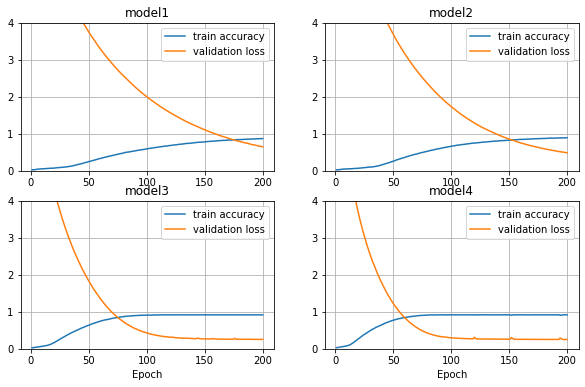

In [60]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))

plt.subplot(221)
plt.plot(xs1, y_acc1, label='train accuracy')
plt.plot(xs1, y_loss1, label='validation loss')
plt.legend(), plt.grid(), plt.title('model1')
plt.ylim(0,4)

plt.subplot(222)
plt.plot(xs2, y_acc2, label='train accuracy')
plt.plot(xs2, y_loss2, label='validation loss')
plt.legend(), plt.grid(), plt.title('model2')
plt.ylim(0,4)

plt.subplot(223)
plt.plot(xs3, y_acc3, label='train accuracy')
plt.plot(xs3, y_loss3, label='validation loss')
plt.legend(), plt.grid(), plt.title('model3')
plt.xlabel('Epoch'), plt.ylim(0,4)

plt.subplot(224)
plt.plot(xs4, y_acc4, label='train accuracy')
plt.plot(xs4, y_loss4, label='validation loss')
plt.legend(), plt.grid(), plt.title('model4')
plt.xlabel('Epoch'),plt.ylim(0,4)

plt.show()